# K-FCA Movie Recommendation Example

This notebook demonstrates K-FCA on a movie rating dataset using four different semirings.

## Dataset
- **5 users** (objects): User_1, User_2, User_3, User_4, User_5
- **4 movies** (attributes): Movie_A, Movie_B, Movie_C, Movie_D
- **Values**: Continuous ratings [0.0 - 1.0] representing user preferences

## Use Case
Find groups of users with similar movie preferences to make recommendations.

In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.context import KValuedContext
from src.galois import GaloisConnection
from src.lattice import ConceptLattice
from src.semirings import BooleanSemiring, MaxPlusSemiring, MinPlusSemiring, FuzzySemiring
from src.visualization import plot_context, plot_lattice

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Dataset Definition

User ratings for 4 movies on a scale of 0 (dislike) to 1 (like).

In [2]:
# Define users (objects)
users = ["User_1", "User_2", "User_3", "User_4", "User_5"]

# Define movies (attributes)
movies = ["Movie_A", "Movie_B", "Movie_C", "Movie_D"]

# User-Movie rating matrix
# Values represent preference/rating in [0, 1]
relation = np.array([
    # Movie_A  Movie_B  Movie_C  Movie_D
    [0.9,     0.8,     0.2,     0.1],  # User_1: likes A, B
    [0.7,     0.9,     0.3,     0.2],  # User_2: likes A, B
    [0.2,     0.3,     0.8,     0.9],  # User_3: likes C, D
    [0.1,     0.2,     0.7,     0.8],  # User_4: likes C, D
    [0.8,     0.7,     0.1,     0.3],  # User_5: likes A, B
], dtype=object)

print("Movie Rating Dataset (5 users × 4 movies)")
print("=" * 70)
print()
print("Rating Matrix:")
df = pd.DataFrame(relation, index=users, columns=movies)
print(df)
print()
print("Values: 0.0 (dislike) to 1.0 (like)")
print()
print("Pattern:")
print("  • User_1, User_2, User_5: Prefer Movie_A and Movie_B")
print("  • User_3, User_4: Prefer Movie_C and Movie_D")

Movie Rating Dataset (5 users × 4 movies)

Rating Matrix:
       Movie_A Movie_B Movie_C Movie_D
User_1     0.9     0.8     0.2     0.1
User_2     0.7     0.9     0.3     0.2
User_3     0.2     0.3     0.8     0.9
User_4     0.1     0.2     0.7     0.8
User_5     0.8     0.7     0.1     0.3

Values: 0.0 (dislike) to 1.0 (like)

Pattern:
  • User_1, User_2, User_5: Prefer Movie_A and Movie_B
  • User_3, User_4: Prefer Movie_C and Movie_D


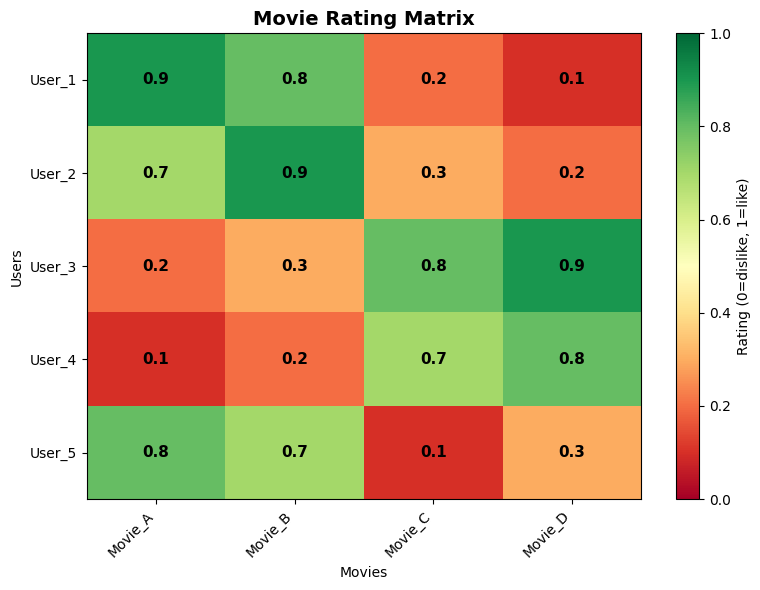

Green = High rating (like), Red = Low rating (dislike)


In [3]:
# Visualize as heatmap
plt.figure(figsize=(8, 6))

# Convert to float for visualization
relation_float = relation.astype(float)
im = plt.imshow(relation_float, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, label='Rating (0=dislike, 1=like)')

# Add value annotations
for i in range(len(users)):
    for j in range(len(movies)):
        text = plt.text(j, i, f'{relation[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=11, fontweight='bold')

# Set ticks and labels
plt.xticks(range(len(movies)), movies, rotation=45, ha='right')
plt.yticks(range(len(users)), users)
plt.title('Movie Rating Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Movies')
plt.ylabel('Users')
plt.tight_layout()
plt.show()

print("Green = High rating (like), Red = Low rating (dislike)")

## 2. Boolean Semiring (Standard FCA)

**Threshold**: φ = 0.7 (consider rating ≥ 0.7 as "likes")

Convert continuous ratings to binary: ≥ 0.7 → 1 (likes), else → 0 (doesn't like)

In [4]:
# Convert to binary using threshold
threshold = 0.7
binary_relation = (relation >= threshold).astype(object).astype(int)

print(f"Boolean Semiring (threshold φ = {threshold})")
print("=" * 70)
print()
print("Binary Relation (1 = likes, 0 = doesn't like):")
df_binary = pd.DataFrame(binary_relation, index=users, columns=movies)
print(df_binary)
print()

# Create Boolean context
boolean_semiring = BooleanSemiring()
boolean_context = KValuedContext(users, movies, binary_relation, boolean_semiring)

print("Context:")
print(boolean_context)

Boolean Semiring (threshold φ = 0.7)

Binary Relation (1 = likes, 0 = doesn't like):
        Movie_A  Movie_B  Movie_C  Movie_D
User_1        1        1        0        0
User_2        1        1        0        0
User_3        0        0        1        1
User_4        0        0        1        1
User_5        1        1        0        0

Context:
K-Valued Formal Context
Semiring: BooleanSemiring(B, ∨, ∧, 0, 1)

         | Movie_A  | Movie_B  | Movie_C  | Movie_D 
----------------------------------------------------
User_1   |    1     |    1     |    0     |    0    
User_2   |    1     |    1     |    0     |    0    
User_3   |    0     |    0     |    1     |    1    
User_4   |    0     |    0     |    1     |    1    
User_5   |    1     |    1     |    0     |    0    


In [5]:
# Build concept lattice
boolean_galois = GaloisConnection(boolean_context, pivot=1)
boolean_lattice = ConceptLattice(boolean_context, boolean_galois, method="objects")

print(f"Boolean Semiring: Found {len(boolean_lattice)} concepts")
print("=" * 70)
print()

# Display all concepts
for i in range(len(boolean_lattice)):
    objs = boolean_lattice.get_concept_objects(i)
    attrs = boolean_lattice.get_concept_attributes(i)
    
    print(f"Concept #{i}:")
    print(f"  Users:  {{{', '.join(objs) if objs else '∅'}}}")
    print(f"  Movies: {{{', '.join(attrs) if attrs else '∅'}}}")
    
    # Interpretation
    if objs and attrs:
        print(f"  → These users like these movies")
    print()

Boolean Semiring: Found 4 concepts

Concept #0:
  Users:  {User_1, User_2, User_3, User_4, User_5}
  Movies: {∅}

Concept #1:
  Users:  {User_1, User_2, User_5}
  Movies: {Movie_A, Movie_B}
  → These users like these movies

Concept #2:
  Users:  {User_3, User_4}
  Movies: {Movie_C, Movie_D}
  → These users like these movies

Concept #3:
  Users:  {∅}
  Movies: {Movie_A, Movie_B, Movie_C, Movie_D}



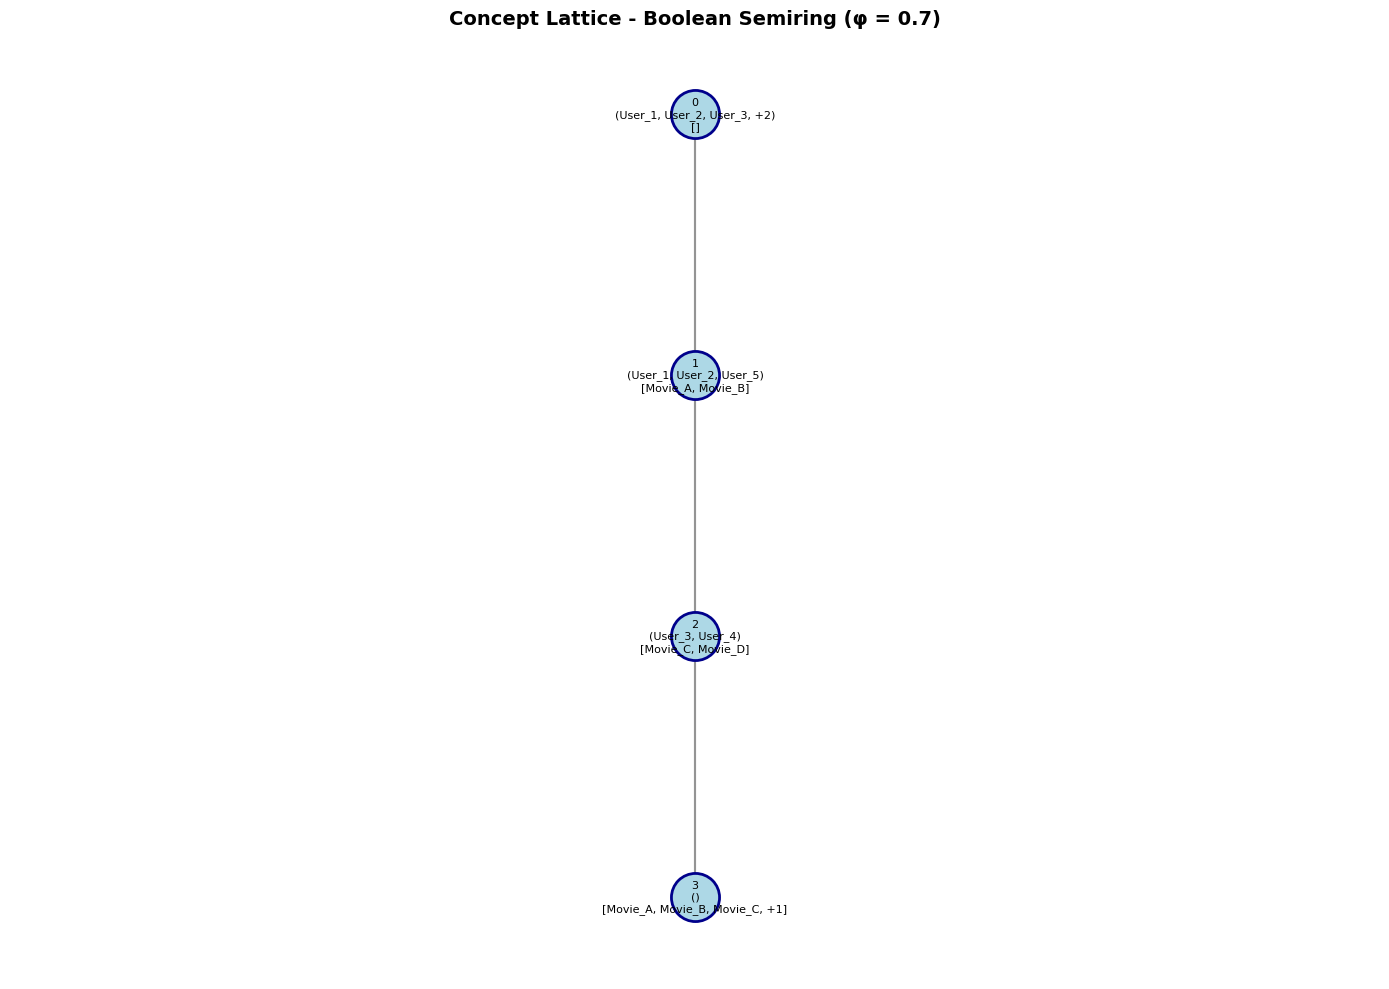

In [6]:
# Visualize Boolean lattice
fig = plot_lattice(boolean_lattice, figsize=(14, 10), layout="hierarchical",
                   title="Concept Lattice - Boolean Semiring (φ = 0.7)")
plt.tight_layout()
plt.show()

### Boolean Analysis

**User Groups Identified**:
- Group 1: Users who like Movie_A and Movie_B
- Group 2: Users who like Movie_C and Movie_D

**Recommendation Strategy**: Users in the same concept can be recommended movies they haven't rated highly yet.

## 3. Max-Plus Semiring (Tropical)

**Transformation**: log(rating) for rating > 0, -∞ for rating = 0

**Pivot**: φ = log(0.7) ≈ -0.357

**Interpretation**: Emphasizes users' **highest-rated movies**

In [7]:
# Transform to log-scale for Max-Plus
maxplus_relation = np.zeros_like(relation, dtype=object)

for i in range(relation.shape[0]):
    for j in range(relation.shape[1]):
        val = float(relation[i, j])
        if val == 0:
            maxplus_relation[i, j] = float('-inf')
        else:
            maxplus_relation[i, j] = np.log(val)

print("Max-Plus Semiring (log-scale transformation)")
print("=" * 70)
print()
print("Log-scaled Ratings:")
df_maxplus = pd.DataFrame(maxplus_relation, index=users, columns=movies)
print(df_maxplus)
print()

# Create Max-Plus context
maxplus_semiring = MaxPlusSemiring()
maxplus_context = KValuedContext(users, movies, maxplus_relation, maxplus_semiring)

print("Context:")
print(maxplus_context)

Max-Plus Semiring (log-scale transformation)

Log-scaled Ratings:
         Movie_A   Movie_B   Movie_C   Movie_D
User_1 -0.105361 -0.223144 -1.609438 -2.302585
User_2 -0.356675 -0.105361 -1.203973 -1.609438
User_3 -1.609438 -1.203973 -0.223144 -0.105361
User_4 -2.302585 -1.609438 -0.356675 -0.223144
User_5 -0.223144 -0.356675 -2.302585 -1.203973

Context:
K-Valued Formal Context
Semiring: MaxPlusSemiring(ℝ∪{-∞,∞}, max, +, -∞, 0)

         | Movie_A  | Movie_B  | Movie_C  | Movie_D 
----------------------------------------------------
User_1   | -0.10536051565782628 | -0.2231435513142097 | -1.6094379124341003 | -2.3025850929940455
User_2   | -0.35667494393873245 | -0.10536051565782628 | -1.2039728043259361 | -1.6094379124341003
User_3   | -1.6094379124341003 | -1.2039728043259361 | -0.2231435513142097 | -0.10536051565782628
User_4   | -2.3025850929940455 | -1.6094379124341003 | -0.35667494393873245 | -0.2231435513142097
User_5   | -0.2231435513142097 | -0.35667494393873245 | -2.30258509

In [8]:
# Build concept lattice with pivot = log(0.7)
phi_maxplus = np.log(0.7)
maxplus_galois = GaloisConnection(maxplus_context, pivot=phi_maxplus)
maxplus_lattice = ConceptLattice(maxplus_context, maxplus_galois, method="objects")

print(f"Max-Plus Semiring: Found {len(maxplus_lattice)} concepts")
print(f"Pivot: φ = log(0.7) ≈ {phi_maxplus:.3f}")
print("=" * 70)
print()

# Display all concepts
for i in range(len(maxplus_lattice)):
    objs = maxplus_lattice.get_concept_objects(i)
    attrs = maxplus_lattice.get_concept_attributes(i)
    
    print(f"Concept #{i}:")
    print(f"  Users:  {{{', '.join(objs) if objs else '∅'}}}")
    print(f"  Movies: {{{', '.join(attrs) if attrs else '∅'}}}")
    print()

Max-Plus Semiring: Found 4 concepts
Pivot: φ = log(0.7) ≈ -0.357

Concept #0:
  Users:  {User_2}
  Movies: {Movie_A, Movie_B}

Concept #1:
  Users:  {User_3}
  Movies: {Movie_C, Movie_D}

Concept #2:
  Users:  {User_3, User_4}
  Movies: {Movie_C, Movie_D}

Concept #3:
  Users:  {User_5}
  Movies: {Movie_A, Movie_B}



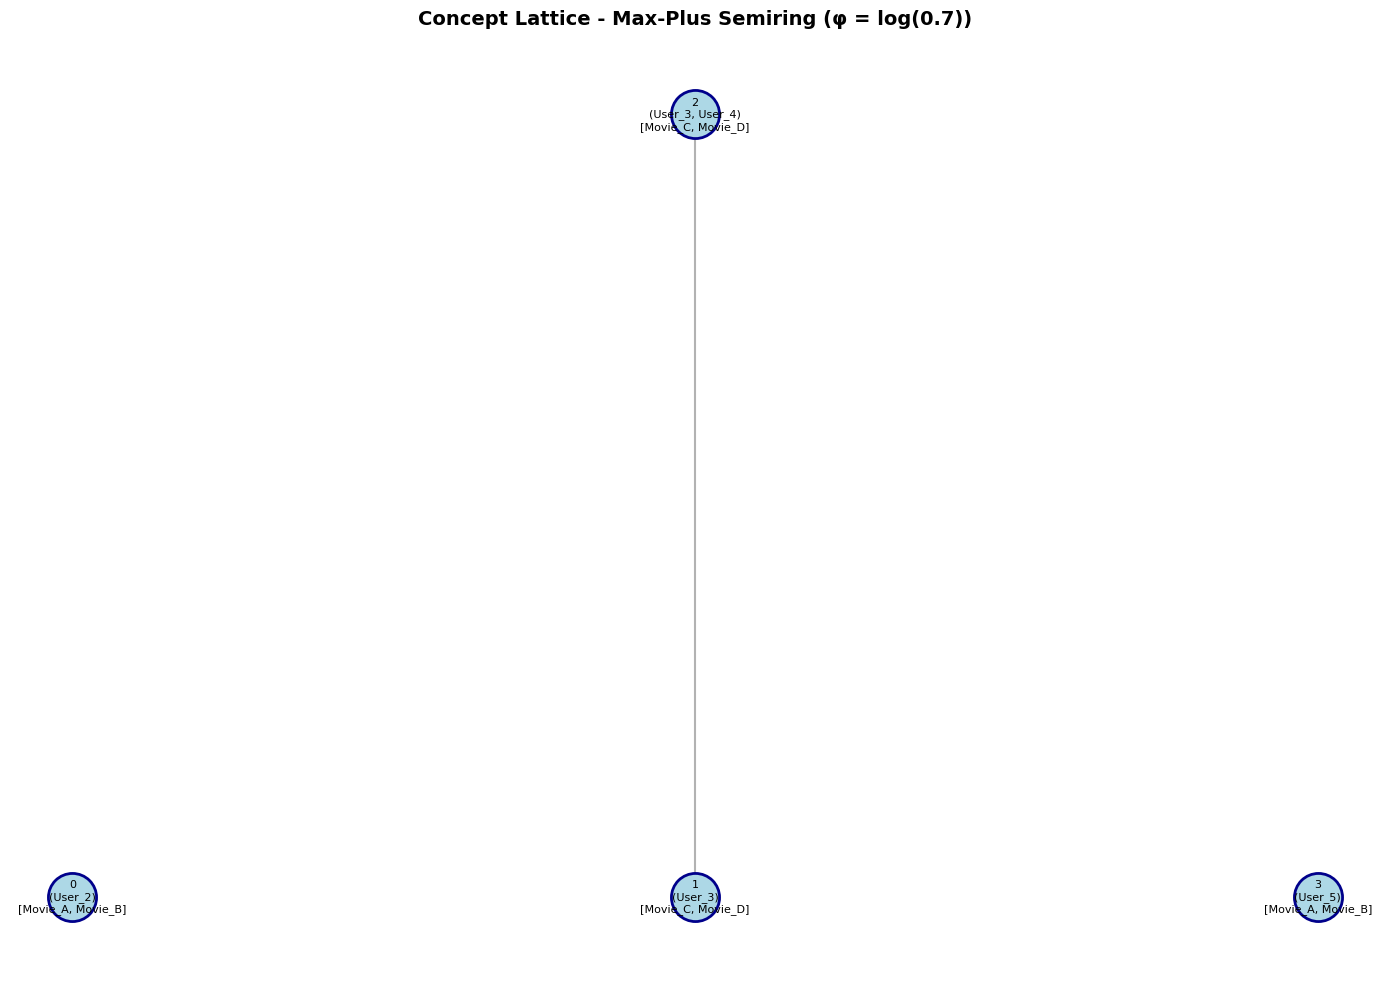

In [9]:
# Visualize Max-Plus lattice
fig = plot_lattice(maxplus_lattice, figsize=(14, 10), layout="hierarchical",
                   title="Concept Lattice - Max-Plus Semiring (φ = log(0.7))")
plt.tight_layout()
plt.show()

### Max-Plus Analysis

**Advantages**:
- Preserves continuous rating information
- Emphasizes highest-rated movies (max operation)
- Can distinguish between 0.7 and 0.9 ratings

**Use Case**: Find users who **strongly like** the same movies (not just "like")

## 4. Min-Plus Semiring (Arctic)

**Transformation**: 1 - rating (inverted)

**Pivot**: φ = 0.3 (corresponds to original 0.7)

**Interpretation**: Emphasizes **consistent preferences** (no low-rated movies)

In [10]:
# Transform using inversion for Min-Plus
minplus_relation = np.zeros_like(relation, dtype=object)

for i in range(relation.shape[0]):
    for j in range(relation.shape[1]):
        val = float(relation[i, j])
        if val == 0:
            minplus_relation[i, j] = float('inf')
        else:
            # Invert: high rating → low number (wins in min)
            minplus_relation[i, j] = 1.0 - val

print("Min-Plus Semiring (inverted values: 1-x)")
print("=" * 70)
print()
print("Inverted Ratings:")
df_minplus = pd.DataFrame(minplus_relation, index=users, columns=movies)
print(df_minplus)
print()
print("Note: Lower values = higher original ratings")
print()

# Create Min-Plus context
minplus_semiring = MinPlusSemiring()
minplus_context = KValuedContext(users, movies, minplus_relation, minplus_semiring)

print("Context:")
print(minplus_context)

Min-Plus Semiring (inverted values: 1-x)

Inverted Ratings:
       Movie_A Movie_B Movie_C Movie_D
User_1     0.1     0.2     0.8     0.9
User_2     0.3     0.1     0.7     0.8
User_3     0.8     0.7     0.2     0.1
User_4     0.9     0.8     0.3     0.2
User_5     0.2     0.3     0.9     0.7

Note: Lower values = higher original ratings

Context:
K-Valued Formal Context
Semiring: MinPlusSemiring(ℝ∪{-∞,∞}, min, +, ∞, 0)

         | Movie_A  | Movie_B  | Movie_C  | Movie_D 
----------------------------------------------------
User_1   | 0.09999999999999998 | 0.19999999999999996 |   0.8    |   0.9   
User_2   | 0.30000000000000004 | 0.09999999999999998 |   0.7    |   0.8   
User_3   |   0.8    |   0.7    | 0.19999999999999996 | 0.09999999999999998
User_4   |   0.9    |   0.8    | 0.30000000000000004 | 0.19999999999999996
User_5   | 0.19999999999999996 | 0.30000000000000004 |   0.9    |   0.7   


In [11]:
# Build concept lattice with pivot = 0.3
phi_minplus = 0.3
minplus_galois = GaloisConnection(minplus_context, pivot=phi_minplus)
minplus_lattice = ConceptLattice(minplus_context, minplus_galois, method="objects")

print(f"Min-Plus Semiring: Found {len(minplus_lattice)} concepts")
print(f"Pivot: φ = {phi_minplus} (inverted from original 0.7)")
print("=" * 70)
print()

# Display all concepts
for i in range(len(minplus_lattice)):
    objs = minplus_lattice.get_concept_objects(i)
    attrs = minplus_lattice.get_concept_attributes(i)
    
    print(f"Concept #{i}:")
    print(f"  Users:  {{{', '.join(objs) if objs else '∅'}}}")
    print(f"  Movies: {{{', '.join(attrs) if attrs else '∅'}}}")
    print()

Min-Plus Semiring: Found 5 concepts
Pivot: φ = 0.3 (inverted from original 0.7)

Concept #0:
  Users:  {User_1}
  Movies: {Movie_C, Movie_D}

Concept #1:
  Users:  {User_2}
  Movies: {Movie_A, Movie_C, Movie_D}

Concept #2:
  Users:  {User_3}
  Movies: {Movie_A, Movie_B}

Concept #3:
  Users:  {User_4}
  Movies: {Movie_A, Movie_B, Movie_C}

Concept #4:
  Users:  {User_5}
  Movies: {Movie_B, Movie_C, Movie_D}



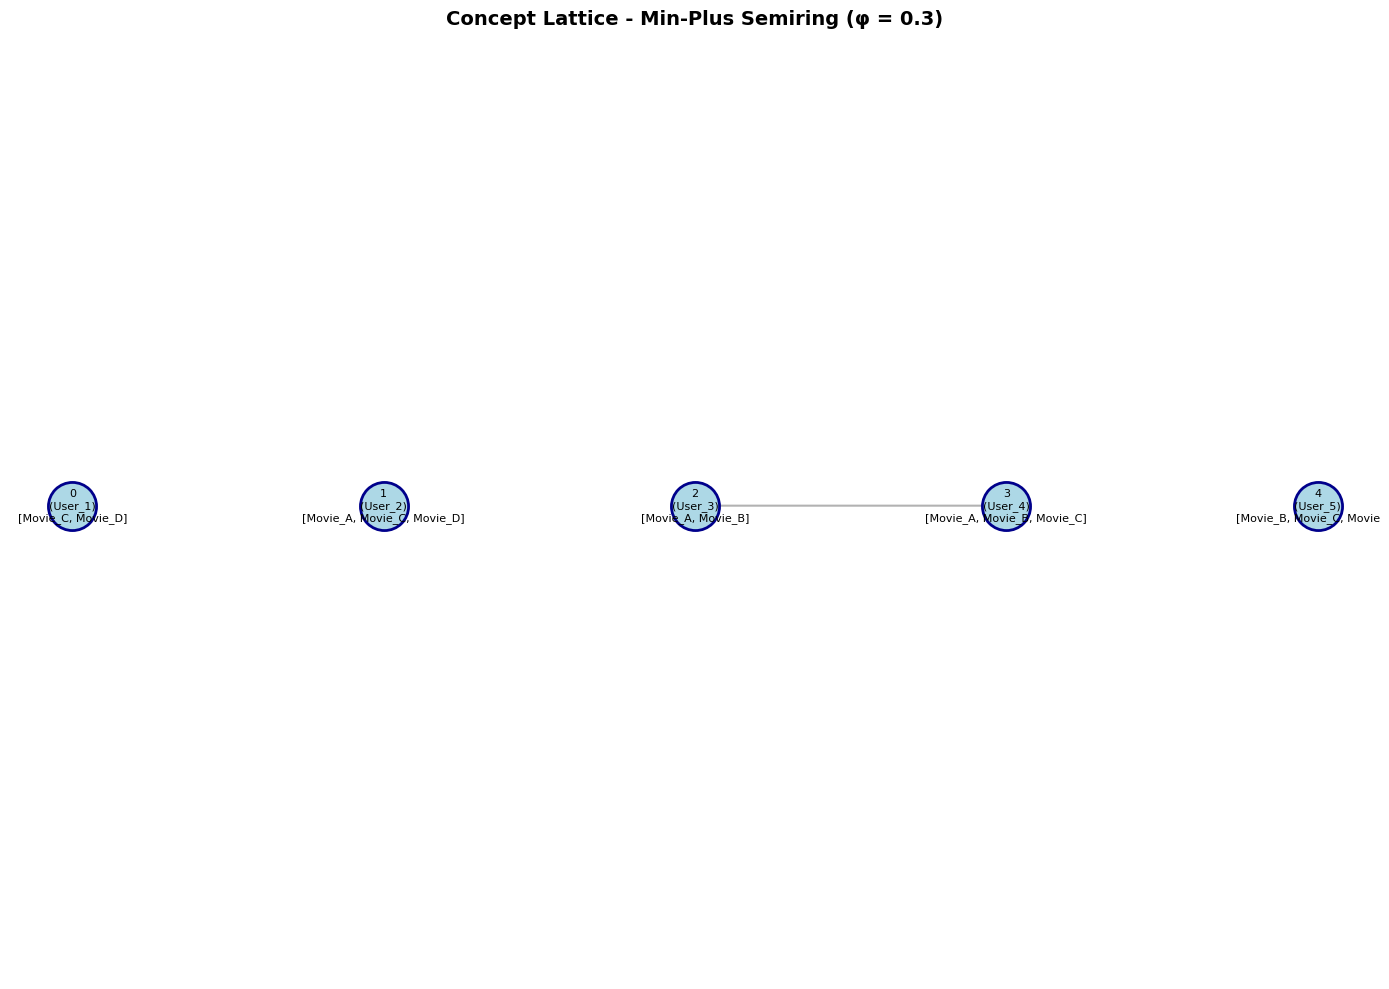

In [12]:
# Visualize Min-Plus lattice
fig = plot_lattice(minplus_lattice, figsize=(14, 10), layout="hierarchical",
                   title="Concept Lattice - Min-Plus Semiring (φ = 0.3)")
plt.tight_layout()
plt.show()

### Min-Plus Analysis

**Characteristics**:
- Very restrictive ("weakest link" approach)
- ALL users in a group must rate ALL shared movies highly
- Often produces fewer concepts

**Use Case**: Find **unanimous preferences** - movies that ALL users in a group rate highly

## 5. Fuzzy FCA via α-cuts

**Main threshold**: α = 0.7

Explore multiple confidence levels to understand preference patterns.

In [13]:
# Apply α-cut at 0.7
alpha = 0.7
alpha_cut_relation = (relation >= alpha).astype(object).astype(int)

print(f"Fuzzy FCA with α-cut = {alpha}")
print("=" * 70)
print()
print("α-cut Relation:")
df_alpha = pd.DataFrame(alpha_cut_relation, index=users, columns=movies)
print(df_alpha)
print()

# Create Fuzzy context
fuzzy_context = KValuedContext(users, movies, alpha_cut_relation, BooleanSemiring())
fuzzy_galois = GaloisConnection(fuzzy_context, pivot=1)
fuzzy_lattice = ConceptLattice(fuzzy_context, fuzzy_galois, method="objects")

print(f"Fuzzy FCA (α = {alpha}): Found {len(fuzzy_lattice)} concepts")
print("=" * 70)
print()

# Display all concepts
for i in range(len(fuzzy_lattice)):
    objs = fuzzy_lattice.get_concept_objects(i)
    attrs = fuzzy_lattice.get_concept_attributes(i)
    
    print(f"Concept #{i}:")
    print(f"  Users:  {{{', '.join(objs) if objs else '∅'}}}")
    print(f"  Movies: {{{', '.join(attrs) if attrs else '∅'}}}")
    print()

Fuzzy FCA with α-cut = 0.7

α-cut Relation:
        Movie_A  Movie_B  Movie_C  Movie_D
User_1        1        1        0        0
User_2        1        1        0        0
User_3        0        0        1        1
User_4        0        0        1        1
User_5        1        1        0        0

Fuzzy FCA (α = 0.7): Found 4 concepts

Concept #0:
  Users:  {User_1, User_2, User_3, User_4, User_5}
  Movies: {∅}

Concept #1:
  Users:  {User_1, User_2, User_5}
  Movies: {Movie_A, Movie_B}

Concept #2:
  Users:  {User_3, User_4}
  Movies: {Movie_C, Movie_D}

Concept #3:
  Users:  {∅}
  Movies: {Movie_A, Movie_B, Movie_C, Movie_D}



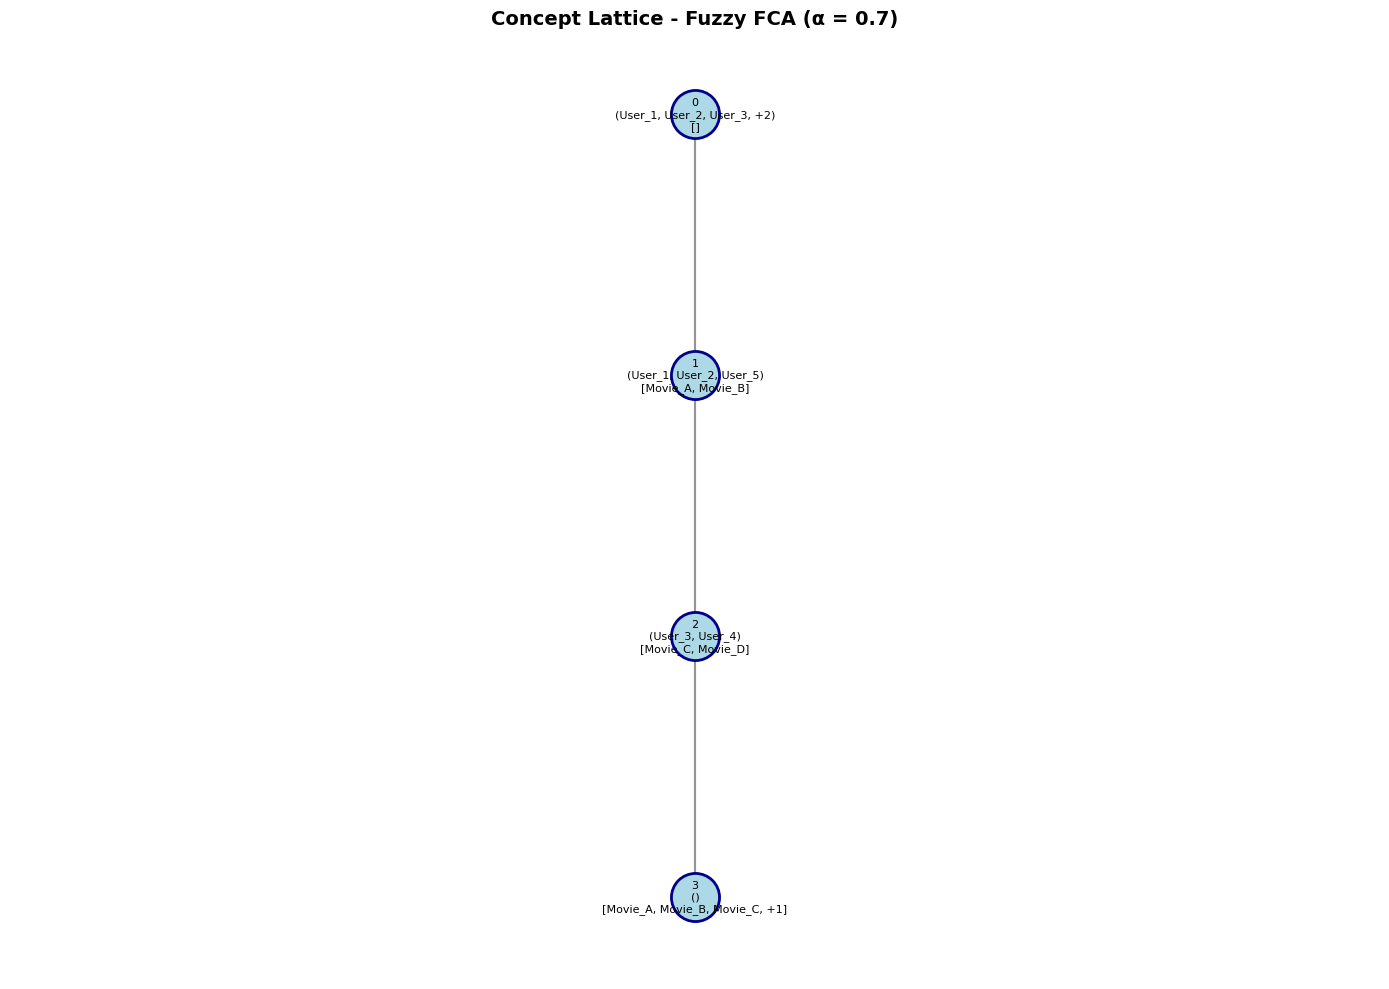

In [14]:
# Visualize Fuzzy lattice
fig = plot_lattice(fuzzy_lattice, figsize=(14, 10), layout="hierarchical",
                   title=f"Concept Lattice - Fuzzy FCA (α = {alpha})")
plt.tight_layout()
plt.show()

### Fuzzy α-cut Hierarchy

Explore different rating thresholds to see how user groups emerge at different confidence levels.

In [15]:
# Explore multiple α-cuts
print("Fuzzy FCA: Concept Hierarchy at Different Rating Thresholds")
print("=" * 70)
print()

alpha_values = [0.0, 0.3, 0.5, 0.7, 0.9]
fuzzy_results = []

for alpha in alpha_values:
    # Apply α-cut
    alpha_rel = (relation >= alpha).astype(object).astype(int)
    ctx = KValuedContext(users, movies, alpha_rel, BooleanSemiring())
    gal = GaloisConnection(ctx, pivot=1)
    lat = ConceptLattice(ctx, gal, method="objects")
    
    fuzzy_results.append((alpha, len(lat)))
    
    # Describe
    if alpha == 0.0:
        desc = "All ratings included"
    elif alpha == 0.3:
        desc = "Low confidence (loose grouping)"
    elif alpha == 0.5:
        desc = "Medium confidence"
    elif alpha == 0.7:
        desc = "High confidence (tight grouping)"
    else:
        desc = "Very high confidence (very tight)"
    
    print(f"α = {alpha:3.1f}: {len(lat):2d} concepts  - {desc}")

print()
print("Observation: Different α levels reveal different user group structures!")

Fuzzy FCA: Concept Hierarchy at Different Rating Thresholds

α = 0.0:  1 concepts  - All ratings included
α = 0.3:  7 concepts  - Low confidence (loose grouping)
α = 0.5:  4 concepts  - Medium confidence
α = 0.7:  4 concepts  - High confidence (tight grouping)
α = 0.9:  5 concepts  - Very high confidence (very tight)

Observation: Different α levels reveal different user group structures!


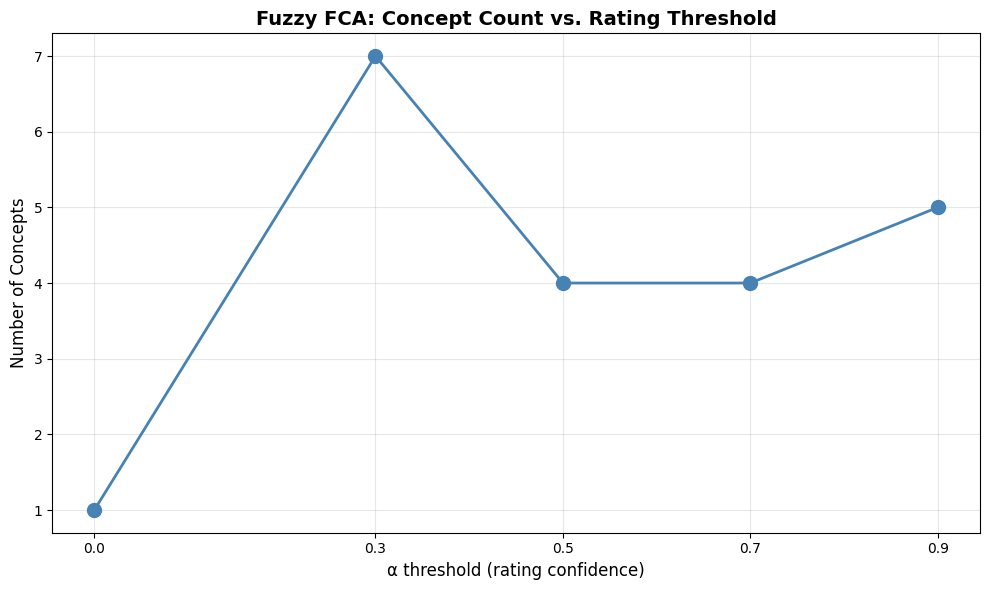


Interpretation:
• Lower α: More users grouped together (looser criteria)
• Higher α: Fewer, tighter groups (stricter criteria)


In [16]:
# Visualize α hierarchy
alphas, counts = zip(*fuzzy_results)

plt.figure(figsize=(10, 6))
plt.plot(alphas, counts, 'o-', linewidth=2, markersize=10, color='steelblue')
plt.xlabel('α threshold (rating confidence)', fontsize=12)
plt.ylabel('Number of Concepts', fontsize=12)
plt.title('Fuzzy FCA: Concept Count vs. Rating Threshold', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(alphas)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• Lower α: More users grouped together (looser criteria)")
print("• Higher α: Fewer, tighter groups (stricter criteria)")

### Fuzzy Analysis

**Advantage of Fuzzy α-cuts**:
- Provides a **hierarchy of recommendations** at different confidence levels
- α = 0.9: Very confident recommendations (users with very similar tastes)
- α = 0.5: Moderate recommendations (users with somewhat similar tastes)
- α = 0.3: Exploratory recommendations (broader user groups)

## 6. Final Comparison

Compare all four semiring approaches for the movie recommendation task.

In [17]:
# Comparison table
print("SEMIRING COMPARISON FOR MOVIE RECOMMENDATIONS")
print("=" * 100)
print()

comparison = [
    ["Semiring", "Threshold", "# Concepts", "Recommendation Strategy"],
    ["-" * 15, "-" * 12, "-" * 10, "-" * 60],
    ["Boolean", "0.7", f"{len(boolean_lattice)}", "Users who 'like' (≥0.7) the same movies"],
    ["Max-Plus", "log(0.7)", f"{len(maxplus_lattice)}", "Users who STRONGLY like the same movies (emphasizes highest)"],
    ["Min-Plus", "0.3", f"{len(minplus_lattice)}", "Users who ALL rate movies highly (unanimous preferences)"],
    ["Fuzzy", "0.7", f"{len(fuzzy_lattice)}", "Multi-level: confident (α=0.9) to exploratory (α=0.3)"],
]

for row in comparison:
    print(f"{row[0]:15s} | {row[1]:12s} | {row[2]:10s} | {row[3]:60s}")

print()
print("User Groups Identified:")
print("-" * 100)
print("Group 1: User_1, User_2, User_5 → Like Movie_A and Movie_B (action/adventure fans)")
print("Group 2: User_3, User_4 → Like Movie_C and Movie_D (drama/romance fans)")

SEMIRING COMPARISON FOR MOVIE RECOMMENDATIONS

Semiring        | Threshold    | # Concepts | Recommendation Strategy                                     
--------------- | ------------ | ---------- | ------------------------------------------------------------
Boolean         | 0.7          | 4          | Users who 'like' (≥0.7) the same movies                     
Max-Plus        | log(0.7)     | 4          | Users who STRONGLY like the same movies (emphasizes highest)
Min-Plus        | 0.3          | 5          | Users who ALL rate movies highly (unanimous preferences)    
Fuzzy           | 0.7          | 4          | Multi-level: confident (α=0.9) to exploratory (α=0.3)       

User Groups Identified:
----------------------------------------------------------------------------------------------------
Group 1: User_1, User_2, User_5 → Like Movie_A and Movie_B (action/adventure fans)
Group 2: User_3, User_4 → Like Movie_C and Movie_D (drama/romance fans)


## 7. Practical Recommendations

### Example Scenario: Recommend movies to User_1

Based on concept analysis:

In [18]:
print("Recommendation for User_1")
print("=" * 70)
print()
print("User_1's ratings:")
print(f"  Movie_A: {relation[0, 0]} (high)")
print(f"  Movie_B: {relation[0, 1]} (high)")
print(f"  Movie_C: {relation[0, 2]} (low)")
print(f"  Movie_D: {relation[0, 3]} (low)")
print()
print("Boolean Semiring Analysis:")
print("  • User_1 belongs to same concept as User_2 and User_5")
print("  • Shared preference: Movie_A, Movie_B")
print("  • Recommendation: None needed (already watched preferred movies)")
print()
print("Max-Plus Semiring Analysis:")
print("  • User_1 groups with users who STRONGLY prefer Movie_A, Movie_B")
print("  • Can distinguish: User_1 (0.9, 0.8) vs User_5 (0.8, 0.7)")
print("  • User_1 has strongest preference → potential influencer for recommendations")
print()
print("Fuzzy Analysis:")
print("  • At α=0.9: User_1 in tight group (very similar users)")
print("  • At α=0.5: User_1 in broader group (include more users)")
print("  • Strategy: Use high α for confident recommendations")
print()
print("Min-Plus Analysis:")
print("  • Very restrictive: finds only unanimous strong preferences")
print("  • Good for 'safe' recommendations everyone will like")

Recommendation for User_1

User_1's ratings:
  Movie_A: 0.9 (high)
  Movie_B: 0.8 (high)
  Movie_C: 0.2 (low)
  Movie_D: 0.1 (low)

Boolean Semiring Analysis:
  • User_1 belongs to same concept as User_2 and User_5
  • Shared preference: Movie_A, Movie_B
  • Recommendation: None needed (already watched preferred movies)

Max-Plus Semiring Analysis:
  • User_1 groups with users who STRONGLY prefer Movie_A, Movie_B
  • Can distinguish: User_1 (0.9, 0.8) vs User_5 (0.8, 0.7)
  • User_1 has strongest preference → potential influencer for recommendations

Fuzzy Analysis:
  • At α=0.9: User_1 in tight group (very similar users)
  • At α=0.5: User_1 in broader group (include more users)
  • Strategy: Use high α for confident recommendations

Min-Plus Analysis:
  • Very restrictive: finds only unanimous strong preferences
  • Good for 'safe' recommendations everyone will like


## 8. Summary

### When to Use Each Semiring in Recommendation Systems

| Semiring | Best For | Trade-off |
|----------|----------|----------|
| **Boolean** | Simple "like/dislike" grouping | Loses rating intensity information |
| **Max-Plus** | Finding users with strongest preferences | More complex, emphasizes high ratings |
| **Min-Plus** | Finding unanimous preferences | Very restrictive, fewer groups |
| **Fuzzy** | Multi-level confidence recommendations | Need to analyze multiple α levels |

### Key Insights

1. **Boolean**: Simple, interpretable, but loses nuance (0.7 vs 0.9 both become 1)
2. **Max-Plus**: Preserves rating intensity, good for finding "super fans"
3. **Min-Plus**: Finds consensus preferences, good for group recommendations
4. **Fuzzy**: Flexible hierarchy, can adjust confidence level based on use case

### Recommendation

For **movie recommendations**:
- Use **Fuzzy (α=0.7-0.8)** for balanced recommendations
- Use **Max-Plus** to identify "power users" or influencers
- Use **Boolean** for simple binary classification
- Use **Min-Plus** for group movie night recommendations (everyone must like it!)